In [236]:
import sys
sys.executable

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
from matplotlib import collections  as mc
import random


In [237]:
import os

#large bounding box for final analysis
bbox = [-73.125276,40.845996,-61.913572,46.149860]

#small bounding box for testing
#bbox = [-70.51364, 41.47909, -69.30295, 43.438689999999994]

lonlat_span = [  abs(bbox[0]-bbox[2]) , abs(bbox[1]-bbox[3])  ]

[11.211703999999997, 5.303863999999997]


In [238]:
#gdallocationinfo -xml -wgs84 utm.vrt -117.5 33.75
import subprocess 
import re

def get_bth( obj ):
    test = subprocess.Popen(["gdallocationinfo",
                            "-valonly",
                            "-wgs84",
                            "../data/raw/bathymetry/eval-area/GEBCO2014_-73.12_40.84_-61.91_46.149_30Sec_Geotiff.tif",
                            str(obj[0]),
                            str(obj[1])
                            ], stdout=subprocess.PIPE)  
    output = test.communicate()
    bth = float(output[0].decode("utf-8"))
    return bth
get_bth( [-65.00, 45.00] )
  


def get_sst( obj ):
    sample_sst_file = '../data/raw/aquaMODIS-L2-sst-avg/avgsst/06sstavg.tiff'
    test = subprocess.Popen(["gdallocationinfo",
                            "-valonly",
                            "-wgs84",
                            sample_sst_file,
                            str(obj[0]),
                            str(obj[1])
                            ], stdout=subprocess.PIPE)  
    output = test.communicate()
    val = int(output[0].decode("utf-8"))
    #cel = ((val / 255) * 47) -2    
    return val
#get_sst( [-70.41364, 41.47909] )


pixel_regex = re.compile( r'(?<=pixel=\")[-0-9]{1,4}')
line_regex = re.compile( r'(?<=line=\")[-0-9]{1,4}')
#return pixel, line, i.e. column row
def get_raster_index( lon, lat ):
    base_file = '../data/raw/aquaMODIS-L2-sst-avg/avgsst/baseeval.tif'
    test = subprocess.Popen(["gdallocationinfo",
                            "-xml",
                            "-wgs84",
                            base_file,
                            str(lon),
                            str(lat)
                            ], stdout=subprocess.PIPE)  
    output = test.communicate()
    val = str(output[0].decode("utf-8"))
    pixel = pixel_regex.findall( val )
    line = line_regex.findall( val )
    pixel_val = None if len(pixel) == 0 else int(pixel[0])
    line_val = None if len(line) == 0 else int(line[0])    
    return [pixel_val, line_val]

get_raster_index( -65.00, 45.00)
get_raster_index( -73.025276,46.049860 )
get_raster_index( -73.025276,40.84 )

#-73.125276,40.845996,-61.913572,46.149860

[11, 637]

### make base of numpy array for overlay

In [291]:
import rasterio
import numpy as np

with rasterio.open('../data/raw/bathymetry/eval-area/GEBCO2014_-73.12_40.84_-61.91_46.149_30Sec_Geotiff.tif') as src:
    base_array = np.zeros( src.shape ) 
        
print( len(base_array), len(base_array[0]) )
flat_base_arr = base_array.flatten()


((637, 1345), 1)
(640, 1348)
(640, 1348)
1348
862720


### iterate through grid of bathymetry base

('flat base array len, ', 862720)


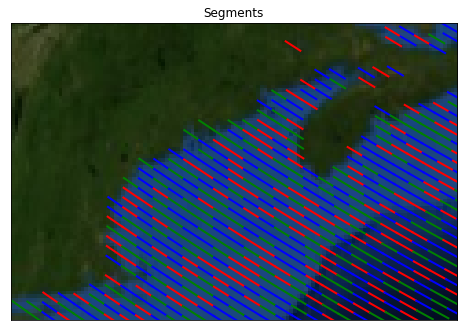

In [315]:
#matplotlib basemap approach

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cass', resolution='i', llcrnrlon=bbox[0], llcrnrlat=bbox[1],
            urcrnrlon=bbox[2], urcrnrlat=bbox[3], 
            width=8E6, height=8E6, 
            lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
m.bluemarble()

ndiv = 30
for lat_index in range( ndiv ):
    
    top = bbox[3] - ( (lonlat_span[1]/ float(ndiv)) * lat_index )
    bottom = top - (lonlat_span[1]/ float(ndiv))
    
    for lon_index in range( ndiv ):

        #get geo coordinates for array index
        left = bbox[0] + ( (lonlat_span[0]/ float(ndiv)) * lon_index )
        right = left + (lonlat_span[0]/ float(ndiv))
        grid_dict = { 'left':left, 'bottom': bottom, 'right':right, 'top':top  }

        #bathymetry info for grid cell
        bth = get_bth([(left+right)/2, (top+bottom)/2])
        #ocean temp for grid cell center
        sst = 0 if bth > 0 else get_sst( [(left+right)/2, (top+bottom)/2] )
        arc = [left, top, right, bottom]      
        r = random.random() * 10
        
        if bth < 0:
            try:
                if r > 6:
                    m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='b')
                elif r < 3:
                    m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='g')
                else: 
                    m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='r')

            except:
                pass
        else:
            pass

plt.title('Segments')

#plt.savefig( '../data/raw/Tow_Routes_zoomin.png' )
#plt.text(x, y, ' Seattle', fontsize=12);
plt.show()

In [307]:

# Register GDAL format drivers and configuration options with a
# context manager.
basefilecopy = '../data/raw/bathymetry/eval-area/bth-base-copy.tif'
#array = np.random.randint(255, size=(100,100)).astype(np.float)

array = reshape_arr

print( array.shape )
print( len(array[3]), min(array[3]), max(array[3]) )

with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = src.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')

    with rasterio.open(basefilecopy, 'w', **profile) as dst:
        dst.write(array.astype(rasterio.uint8), 1)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.


(640, 1348)
(1348, 91.55901426612262, 91.55901426612262)


In [1]:
##color ramp code

import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np

some_matrix = np.random.rand(10,10)
cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#244162','#DCE6F1'], N=256)
plt.matshow(some_matrix, cmap=cmap)
plt.show()

[[0.2053009  0.36328189 0.95650176 0.56004699 0.27363472 0.94511797
  0.26852267 0.97239602 0.57636886 0.94961929]
 [0.27595817 0.14871287 0.2934796  0.49754391 0.96912152 0.56724002
  0.20130102 0.53179097 0.82772217 0.85605187]
 [0.88971908 0.88665788 0.44737297 0.19160466 0.31659296 0.59209667
  0.56830469 0.59923878 0.76962335 0.0879825 ]
 [0.08484047 0.16143173 0.04825683 0.33527814 0.86383043 0.79658415
  0.26072498 0.48895495 0.01640843 0.18439166]
 [0.0778922  0.34588879 0.1261693  0.1174895  0.73923232 0.94475713
  0.2017811  0.22191675 0.83944999 0.13741635]
 [0.65180086 0.39823571 0.39957409 0.10791455 0.26027884 0.20072408
  0.6072391  0.61964681 0.2519413  0.67508201]
 [0.23162035 0.36269489 0.44114965 0.31946537 0.98726452 0.04659356
  0.14640376 0.2005976  0.90391633 0.85143369]
 [0.76290742 0.05985631 0.01453429 0.6686886  0.09220223 0.36689561
  0.64427015 0.57438237 0.14137827 0.42726131]
 [0.38164557 0.26689059 0.80440383 0.02962953 0.65190255 0.66496149
  0.80224763

<Figure size 480x480 with 1 Axes>

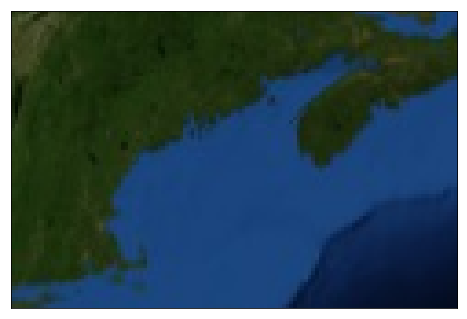

In [109]:
box = [-73.125276,40.845996,-61.913572,46.149860]

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cass', resolution='i', llcrnrlon=box[0], llcrnrlat=box[1],
            urcrnrlon=box[2], urcrnrlat=box[3], 
            width=8E6, height=8E6, 
            lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
m.bluemarble()

In [ ]:
#for numpy array overlay geotiff approach - on hold

ndiv = 10

for lat_index in range( ndiv ):
    
    top = bbox[3] - ( (lonlat_span[1]/ float(ndiv)) * lat_index )
    bottom = top - (lonlat_span[1]/ float(ndiv))
    
    for lon_index in range( ndiv ):
        
        print( "looking at lonlat index ", lon_index, lat_index  )
        
        #get geo coordinates for array index
        left = bbox[0] + ( (lonlat_span[0]/ float(ndiv)) * lon_index )
        right = left + (lonlat_span[0]/ float(ndiv))
        grid_dict = { 'left':left, 'bottom': bottom, 'right':right, 'top':top  }

        #bathymetry info for grid cell
        bth = get_bth([(left+right)/2, (top+bottom)/2])
        #ocean temp for grid cell center
        sst = 0 if bth > 0 else get_sst( [(left+right)/2, (top+bottom)/2] )
   
        
        lt_ind = get_raster_index( left, top )        
        if lt_ind[0] == -1:
            lt_ind[0] = 0
        if lt_ind[1] == -1:
            lt_ind[1] = 0
        
        rb_ind = get_raster_index( right, bottom )
        if rb_ind[0] == -1:
            rb_ind[0] = 0
        if rb_ind[1] == -1:
            rb_ind[1] = 0   

        rowlen = len(flat_base_arr) / ndiv
        collen = len(flat_base_arr) / ndiv**2
        
        for rowdiv in range( ndiv ):
            row_offset = rowdiv * rowlen
            for coldiv in range(ndiv):                 
                col_offset = (coldiv * collen)
                col_end = col_offset + collen
                random_grey = random.random() * 255
                flat_base_arr[ row_offset + col_offset : row_offset + col_end ] = random_grey             

reshape_arr = flat_base_arr.reshape(base_array.shape)